#Navigation Analysis Metrics for Didactics
Made by: Wilfredo Aaron Sosa Ramos

In [1]:
!pip install -q langchain langchain_core langchain_community langgraph langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.7 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)


_set_env("GOOGLE_API_KEY")

In [32]:
# First we initialize the model we want to use.
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)

# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal
from pydantic import BaseModel, Field
from typing import Dict, List

# Define the Pydantic schema
class UserInfo(BaseModel):
    name: str = Field(..., description="The full name of the user")
    age: int = Field(..., description="The user's age")
    grade_level: str = Field(..., description="The current educational grade level of the user, e.g., '10th Grade'")
    subjects: List[str] = Field(..., description="A list of subjects the user is enrolled in or interested in, e.g., ['Math', 'Literature']")
    interaction_history: List[str] = Field(..., description="A chronological list of interactions or activities of the user, e.g., ['Completed assignment on algebra', 'Participated in group discussion']")

# Define Metrics and Results classes
class Metrics(BaseModel):
    dominio_competencias: float = Field(..., description="Basic skills mastery.")
    progreso_conceptos: float = Field(..., description="Progress in understanding key concepts.")
    resolucion_problemas: float = Field(..., description="Ability to solve complex problems.")
    fluidez_produccion: float = Field(..., description="Fluency in written or mathematical production.")
    retencion_conocimientos: float = Field(..., description="Retention and transfer of knowledge.")
    participacion: float = Field(..., description="Active participation and engagement.")
    autoeficacia: float = Field(..., description="Self-efficacy and learning attitudes.")
    comunicacion_argumentacion: float = Field(..., description="Communication and argumentation skills.")
    analisis_critico: float = Field(..., description="Critical analysis capability.")
    aprendizaje_personalizado: float = Field(..., description="Indicators of personalized learning.")
    curso: str = Field(..., description="Name of the course.")

class Results(BaseModel):
    metrics: List[Metrics] = Field(..., description="List of calculated metrics for each course.")

from langchain.schema import SystemMessage, HumanMessage
from langchain_core.output_parsers import JsonOutputParser

def calculate_metrics_llm(state):
    """
    Calculates educational metrics for a specific course using LLM.
    The request is in English, but the response is in Spanish.
    """
    json_parser = JsonOutputParser(pydantic_object=Results)
    messages = [
        SystemMessage(content="You are an educational analyst specialized in evaluating learning metrics."),
        HumanMessage(content=f"""
        Evaluate the following metrics for the courses '{state['user_info'].subjects}':
        - Interaction history: {state['user_info'].interaction_history}
        - Student's grade level: {state['user_info'].grade_level}

        Provide numerical values (0-100) for the following metrics:
        1. Dominio de competencias básicas.
        2. Progreso en la comprensión de conceptos clave.
        3. Resolución de problemas complejos.
        4. Fluidez en la producción escrita o matemática.
        5. Retención y transferencia de conocimientos.
        6. Participación activa y compromiso.
        7. Autoeficacia y actitudes hacia el aprendizaje.
        8. Habilidad de comunicación y argumentación.
        9. Capacidad de análisis crítico.
        10. Indicadores de aprendizaje personalizado.

        Your response should be in Spanish in the following JSON format:
        {json_parser.get_format_instructions()}
        """)
    ]

    response = model.invoke(messages)
    parsed_result = json_parser.parse(response.content)

    print(f"CALCULATE METRICS: {parsed_result}")

    return {
        "metrics": parsed_result
    }

class Analysis(BaseModel):
    analysis: str = Field(..., description="Analysis based in the calculated metrics.")
    conclusions: str = Field(..., description="Generated conclusions from the analysis.")

def generate_analysis_llm(state):
    """
    Generates analysis and conclusions based on calculated metrics.
    The request is in English, but the response is in Spanish.
    """
    json_parser = JsonOutputParser(pydantic_object=Analysis)
    messages = [
        SystemMessage(content="You are an educational analysis expert specializing in generating insights."),
        HumanMessage(content=f"""
        Based on the following metrics for the courses '{state['user_info'].subjects}':
        {state['metrics']}

        Generate:
        1. A detailed analysis of the metrics.
        2. Practical conclusions and actionable recommendations for improving student learning.

        Your response should be in Spanish in the following JSON format:
        {json_parser.get_format_instructions()}
        """)
    ]

    response = model.invoke(messages)
    parsed_result = json_parser.parse(response.content)

    print(f"GENERATE ANALYSIS AND CONCLUSIONS: {parsed_result}")

    return {
        "analysis": parsed_result
    }

import matplotlib.pyplot as plt
def export_metrics_graph(state):
    """
    Generates and exports a bar chart for each set of metrics in the results.

    Args:
        results (Results): The list of metrics for each course.
        output_directory (str): Directory where the charts will be saved.

    Returns:
        dict: Status and paths of saved images.
    """
    saved_paths = []

    for metric in state['metrics']['metrics']:
        labels = [
            "Basic Skills", "Concept Progress", "Problem Solving",
            "Fluency", "Knowledge Retention", "Participation",
            "Self-Efficacy", "Communication", "Critical Analysis", "Personalized Learning"
        ]
        values = [
            metric['dominio_competencias'], metric['progreso_conceptos'], metric['resolucion_problemas'],
            metric['fluidez_produccion'], metric['retencion_conocimientos'], metric['participacion'],
            metric['autoeficacia'], metric['comunicacion_argumentacion'], metric['analisis_critico'],
            metric['aprendizaje_personalizado']
        ]

        plt.figure(figsize=(10, 6))
        plt.bar(labels, values, color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Metrics for the Course: {metric['curso']}")
        plt.ylabel("Score (0-100)")
        plt.tight_layout()

        # Save the chart
        file_path = f"{state['output_directory']}/{metric['curso'].replace(' ', '_')}_metrics.png"
        plt.savefig(file_path)
        plt.close()

        saved_paths.append(file_path)

    print(f"IMAGES SAVED SUCCESSFULLY: {saved_paths}")

    return {
        "img_status": "ok",
        "saved_images": saved_paths
    }

In [33]:
from typing import TypedDict, Any

class GraphState(TypedDict):
    user_info: UserInfo
    output_directory: str

    metrics: Results
    analysis: Analysis
    img_status: str
    saved_images: list[str]

In [34]:
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)

In [35]:
from langgraph.graph import END

workflow.add_node("calculate_metrics_llm", calculate_metrics_llm)
workflow.add_node("generate_analysis_llm", generate_analysis_llm)
workflow.add_node("export_metrics_graph", export_metrics_graph)

workflow.set_entry_point("calculate_metrics_llm")
workflow.add_edge('calculate_metrics_llm', "generate_analysis_llm")
workflow.add_edge('generate_analysis_llm', "export_metrics_graph")
workflow.add_edge('export_metrics_graph', END)

In [36]:
app = workflow.compile()

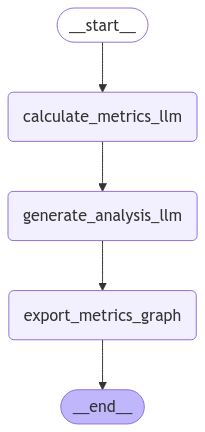

In [37]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [38]:
user_info = UserInfo(
    name="Wilfredo Aaron Sosa Ramos",
    age=22,
    grade_level="Universidad",
    subjects=["Estadística Descriptiva e Inferencial", "Cálculo Integral", "Teoría de Diseño Curricular"],
    interaction_history=[
        "Obtuvo 20 en el examen de Estadística Inferencial",
        "Participó en el desarrollo de un proyecto de análisis de datos para Estadística Descriptiva",
        "Entregó una tarea sobre integración definida en Cálculo Integral",
        "Diseñó un plan curricular para la asignatura de Matemáticas",
        "Participó en un debate sobre los enfoques de aprendizaje en la educación universitaria",
        "Asistió a una conferencia sobre métodos avanzados de análisis estadístico",
        "Resolvió un conjunto de problemas complejos en Cálculo Integral con una tasa de éxito del 95%",
        "Escribió un ensayo sobre la importancia del diseño curricular",
        "Obtuvo un 18 en la evaluación intermedia de Cálculo Integral",
        "Realizó una presentación sobre la importancia de la educación personalizada"
    ]
)

inputs = {
    "user_info": user_info,
    "output_directory": "/content",
  }

result = app.invoke(inputs)

CALCULATE METRICS: {'metrics': [{'dominio_competencias': 85, 'progreso_conceptos': 80, 'resolucion_problemas': 90, 'fluidez_produccion': 80, 'retencion_conocimientos': 82, 'participacion': 85, 'autoeficacia': 88, 'comunicacion_argumentacion': 75, 'analisis_critico': 80, 'aprendizaje_personalizado': 70, 'curso': 'Estadística Descriptiva e Inferencial'}, {'dominio_competencias': 75, 'progreso_conceptos': 78, 'resolucion_problemas': 92, 'fluidez_produccion': 88, 'retencion_conocimientos': 78, 'participacion': 70, 'autoeficacia': 80, 'comunicacion_argumentacion': 65, 'analisis_critico': 70, 'aprendizaje_personalizado': 60, 'curso': 'Cálculo Integral'}, {'dominio_competencias': 70, 'progreso_conceptos': 75, 'resolucion_problemas': 60, 'fluidez_produccion': 85, 'retencion_conocimientos': 70, 'participacion': 80, 'autoeficacia': 85, 'comunicacion_argumentacion': 85, 'analisis_critico': 88, 'aprendizaje_personalizado': 75, 'curso': 'Teoría de Diseño Curricular'}]}
GENERATE ANALYSIS AND CONCLUS

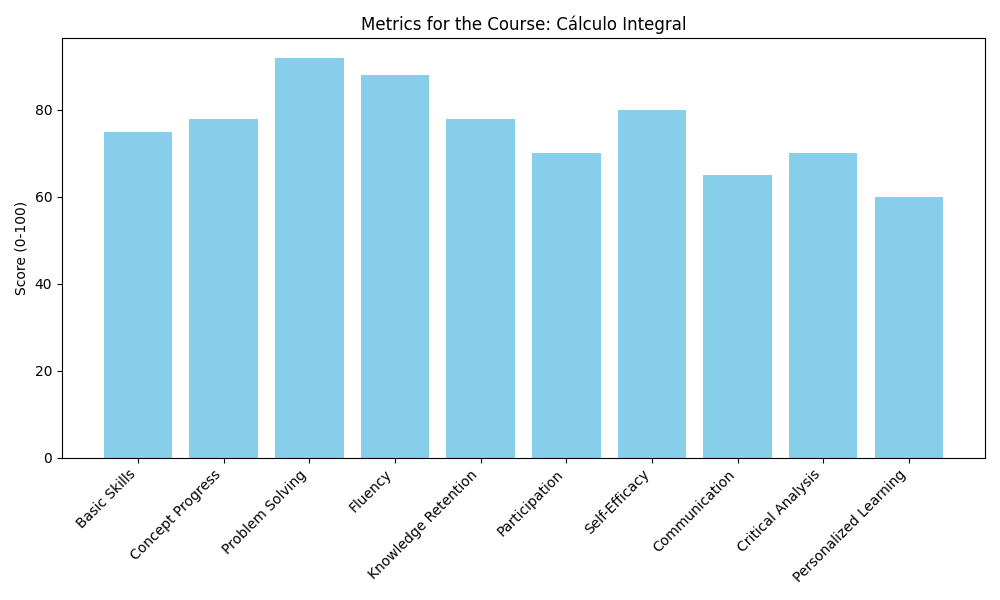

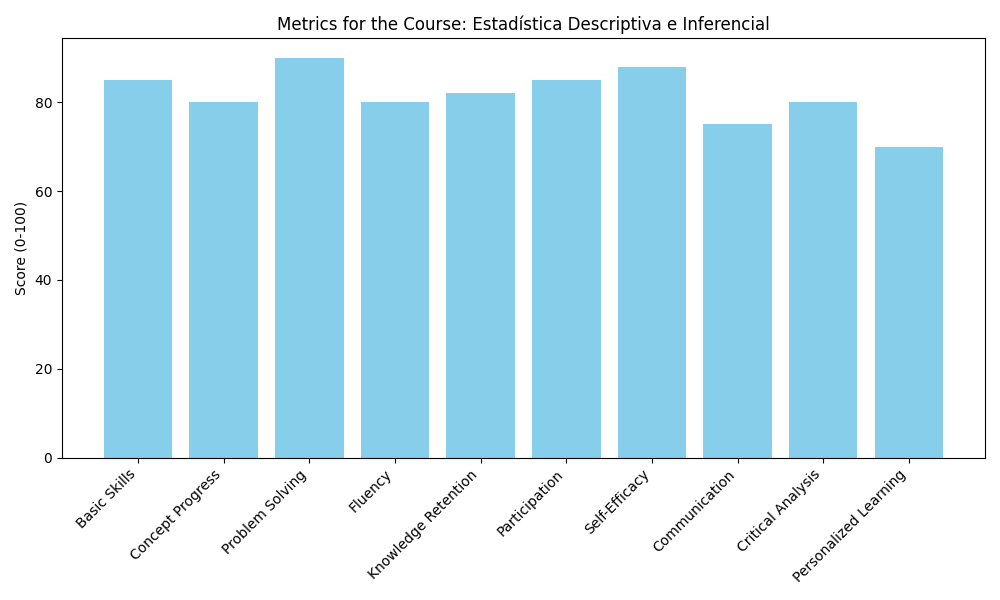

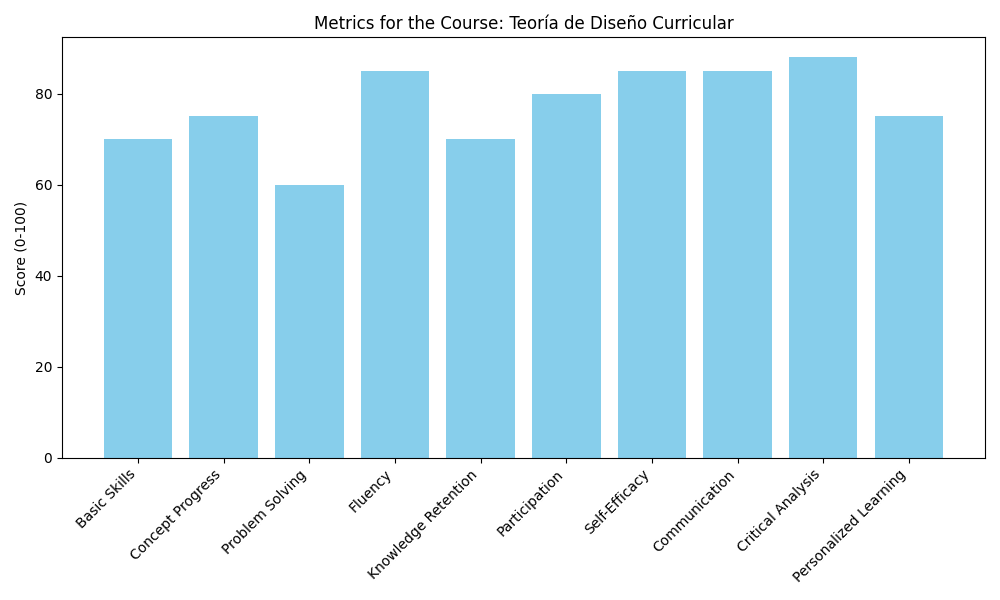